In [3]:
!pip install polars -U lightautoml > istallations.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.0.11 which is incompatible.
fitter 1.7.0 requires joblib<2.0.0,>=1.3.1, but you have joblib 1.2.0 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
osmnx 1.8.1 requires shapely>=2.0, but you have shapely 1.8.5.post1 which is incompatible.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tensorflowjs 4.16.0 requires packaging~=23.1, but you have packagin

In [1]:
!pip install --upgrade pyforest > istallations.txt
!python -m pyforest install_extensions > istallations.txt

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/pyforest/__main__.py", line 22, in <module>
    install_function()
  File "/opt/conda/lib/python3.10/site-packages/pyforest/utils.py", line 21, in install_extensions
    install_labextension()
  File "/opt/conda/lib/python3.10/site-packages/pyforest/utils.py", line 66, in install_labextension
    commands.build()
  File "/opt/conda/lib/python3.10/site-packages/jupyterlab/commands.py", line 507, in build
    return handler.build(
  File "/opt/conda/lib/python3.10/site-packages/jupyterlab/commands.py", line 723, in build
    raise RuntimeError(msg)
RuntimeError: JupyterLab failed to build


In [4]:
import polars as pl
import numpy as np
import pandas as pd
import pyforest
import os
import time
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/sbermarket-internship-competition/sample_submission.csv
/kaggle/input/sbermarket-internship-competition/train.csv


In [13]:
def ohe_data(raw: pl.DataFrame) -> pl.DataFrame:
    """
    Обрабатывает датафрейм polars и OHE датафрейм.

    Args:
        raw (pl.DataFrame): Polars DataFrame для обработки.

    Returns:
        (tpl.DataFrame).
    """

    # OHE 'cart', группировка по юзеру и дате заказа по максимальным значениям
    # Таким образом для каждой категории, если она была в этот день в заказе у пользователя, будет 1
    train_raw = raw.to_dummies(columns='cart').group_by(['user_id', 'order_completed_at']).max()
    train_raw = train_raw.sort(['user_id', 'order_completed_at'])

    # Вычисление порядкового номера заказа для каждого пользователя
    # pl.lit - создает временный столбец, чтобы вычислять 1 и нумерация начиналась с 0
    train_raw = train_raw.with_columns(
        (pl.col('user_id').cum_count() - pl.lit(1)).over(['user_id']).alias('order_number')
    )
    
    return train_raw
    
def t_v_data(train_raw: pl.DataFrame) -> tuple[pl.DataFrame, pl.DataFrame]:
    """
    Обрабатывает датафрейм polars и возвращает обработынный тренировочный и валидационный датасеты.

    Args:
        raw (pl.DataFrame): Polars DataFrame для обработки.

    Returns:
        tuple[pl.DataFrame, pl.DataFrame]: Обработанные DataFrame для train_data и valid_data.
    """
    
    # Удаление даты. ХОТЯ ТУТ МОЖНО ДОСТАТЬ КАКИЕ_ТО ФИЧИ; НАПРИМЕР ВРЕМЯ СУТОК
    # Можно посмотреть следующее вероятное время заказа
    train_raw = train_raw.drop('order_completed_at')
    
    # Группировка по 'user_id' и вычисление максимального номера заказа
    grouped = train_raw.group_by('user_id').agg(pl.max('order_number').alias('max_order_number'))

    # Присоединение к train_raw для получения максимального номера заказа для каждого 'user_id'
    merged = train_raw.join(grouped, on='user_id')

    # Определение последнего заказа для каждого пользователя
    last_order = merged['max_order_number'] == merged['order_number']

    # Разделение на train_data (заказы, кроме последнего) и valid_data (последний заказ)
    train_data = train_raw.filter(~last_order).group_by('user_id').sum()
    valid_data = train_raw.filter(last_order)

    return train_data, valid_data

def Train_create(train_data: pl.DataFrame, valid_data: pl.DataFrame) -> pd.DataFrame:
    """
    Обрабатывает train & val и возвращает укомплектованный pd.Dataframe Train.

    Args:
        train_data (pl.DataFrame): DataFrame с данными обучающего набора.
        valid_data (pl.DataFrame): DataFrame с данными валидационного набора.

    Returns:
        pd.DataFrame: Итоговый DataFrame после обработки.
    """
    # Преобразование в длинный формат
    train_melt = train_data.drop('order_number').melt(id_vars=['user_id'], variable_name='category', value_name='ordered')
    valid_melt = valid_data.drop('order_number').melt(id_vars=['user_id'], variable_name='category', value_name='target')
    
    Train = train_melt
    # Создание DataFrame с информацией о номере заказа для каждого пользователя в valid_data
    order_number_df = valid_data.select(['user_id', 'order_number']).unique()
    Train = Train.join(order_number_df, on='user_id', how='left')

    # Вычисление рейтинга для каждой записи в Train
    Train = Train.with_columns((pl.col('ordered') / pl.col('order_number')).alias('rating'))

    # Формирование уникального идентификатора для каждой записи в Train
    Train = Train.with_columns((pl.col('user_id').cast(pl.Utf8) + ';' + pl.col('category')).alias('id'))

    # Присоединение целевой переменной из valid_melt к Train
    Train = Train.with_columns(valid_melt.select('target'))

    # Расчет суммарного количества заказанных продуктов по каждой категории в Train
    dl_tmp = Train.group_by('category').agg(pl.col(['ordered']).sum())

    # Присоединение информации о суммарном количестве заказанных продуктов к Train
    Train = Train.join(dl_tmp.select('category', 'ordered'), on='category').rename({"ordered_right": "total_ordered"})

    # Преобразование в pandas DataFrame
    Train = Train.to_pandas()
    Train['id'] = Train['id'].str.replace('cart_', '')
    Train['category'] = Train['category'].str.replace('cart_', '')

    return Train

In [40]:
raw = pd.read_csv('../input/sbermarket-internship-competition/train.csv')
sub = pd.read_csv('../input/sbermarket-internship-competition/sample_submission.csv', sep = ",")

# Приведение столбца 'cart' к типу string
raw['cart'] = raw['cart'].astype(int)

In [34]:
users = []
carts = []

for row in sub.to_numpy():
    user, cart = map(int, row[0].split(';'))
    users.append(user)
    carts.append(cart)

users = list(set(users))
carts = list(set(carts))

int

In [41]:
raw = raw[raw['user_id'].isin(users)]
raw = raw[raw['cart'].isin(carts)]

In [42]:
raw

,user_id,order_completed_at,cart
16,3,2015-06-18 16:15:33,399
17,3,2015-07-04 14:05:22,399
18,4,2015-07-08 06:59:04,54
19,4,2015-07-08 06:59:04,55
20,5,2015-07-22 08:16:24,409
...,...,...,...
3123059,12702,2020-09-03 23:45:45,441
3123060,12702,2020-09-03 23:45:45,92
3123061,12702,2020-09-03 23:45:45,431
3123062,12702,2020-09-03 23:45:45,24


In [43]:
raw = pl.from_pandas(raw)

In [44]:
%%time
train_raw = ohe_data(raw)
train_data, val_data = t_v_data(train_raw)
Train = Train_create(train_data, val_data)
train_raw

CPU times: user 1min, sys: 17.4 s, total: 1min 17s
Wall time: 1min 2s


user_id,order_completed_at,cart_0,cart_1,cart_10,cart_100,cart_101,cart_102,cart_103,cart_104,cart_105,cart_106,cart_107,cart_108,cart_109,cart_11,cart_110,cart_111,cart_112,cart_113,cart_114,cart_115,cart_116,cart_117,cart_118,cart_119,cart_12,cart_120,cart_121,cart_122,cart_123,cart_124,cart_125,cart_126,cart_127,cart_128,cart_129,…,cart_859,cart_86,cart_860,cart_861,cart_862,cart_863,cart_865,cart_866,cart_867,cart_868,cart_869,cart_87,cart_870,cart_871,cart_872,cart_873,cart_874,cart_875,cart_876,cart_877,cart_878,cart_879,cart_88,cart_880,cart_89,cart_9,cart_90,cart_91,cart_92,cart_93,cart_94,cart_95,cart_96,cart_97,cart_98,cart_99,order_number
i64,str,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u32
0,"""2020-07-19 09:…",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,"""2020-08-24 08:…",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
0,"""2020-09-02 07:…",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1,"""2019-05-08 16:…",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"""2020-01-17 14:…",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"""2020-02-06 22:…",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1,"""2020-03-02 13:…",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1,"""2020-03-29 13:…",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4
1,"""2020-04-14 01:…",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


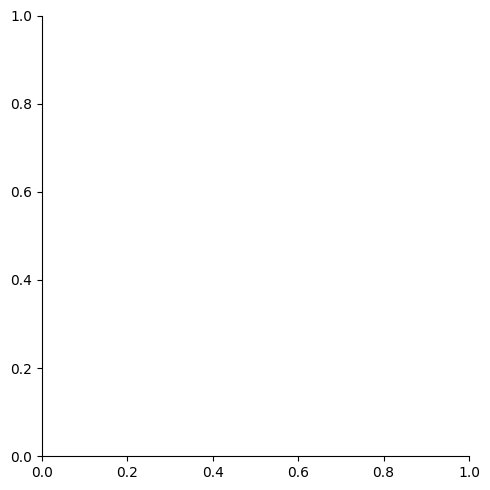

In [10]:
import seaborn as sns

sns.displot()

,user_id,category,ordered,order_number,rating,id,target,total_ordered
0,0,0,0,2,0.000000,0;0,0,16494
1,1,0,0,8,0.000000,1;0,0,16494
2,2,0,1,14,0.071429,2;0,0,16494
3,3,0,0,6,0.000000,3;0,0,16494
4,4,0,0,7,0.000000,4;0,0,16494
...,...,...,...,...,...,...,...,...
17619995,19995,99,0,2,0.000000,19995;99,0,13493
17619996,19996,99,0,2,0.000000,19996;99,0,13493
17619997,19997,99,1,2,0.500000,19997;99,0,13493
17619998,19998,99,0,2,0.000000,19998;99,0,13493


In [106]:
Train_set, Valid_set = train_test_split(Train, test_size = 0.3,
                                        stratify = None, random_state = 23)

In [107]:
%%time 
def f1 (real, pred, **kwargs):
    return f1_score(real, (pred > 0.5).astype(int), **kwargs)

roles = {'target': 'target', 'drop': ['user_id', 'category', 'id']}
task = Task('binary', metric = f1)

automl = TabularAutoML(task = task, 
                       timeout = 300,
                       cpu_limit = 4,
                       reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 23},
                       general_params = {'use_algos': [['linear_l2']]},
                      )
train_pred = automl.fit_predict(Train_set, roles = roles)
print('Score', "%.5f" % f1(Train_set.target, train_pred.data))

valid_pred = automl.predict(Valid_set)
print('Score on out of folds validation', "%.5f" % f1(Valid_set.target, valid_pred.data))

Score 0.30853
Score on out of folds validation 0.30751
CPU times: user 1min 59s, sys: 58.5 s, total: 2min 58s
Wall time: 1min 22s


In [108]:
best_score = 0
for i in np.arange(0.01, 1.0, 0.01):
    score = f1 = f1_score(Valid_set.target, (valid_pred.data > i).astype(int))
    if score > best_score:
        best_score = score
        proba_split = i

print('At i =', "%.2f" % proba_split,'score is : ' "%.5f" % best_score)

At i = 0.12 score is : 0.40421


In [65]:
Test = Train.copy()
Test['order_number'] += 1 
Test['ordered'] = Test['ordered'] + Test['target']
test_total_ordered = Test.groupby('category')['ordered'].sum()
Test['total_ordered'] = Test['category'].map(test_total_ordered)
Test['rating'] = Test['ordered'] / Test['order_number']
Test = Test.drop('target', axis=1)
Test.head(3)

,user_id,category,ordered,order_number,rating,id,total_ordered
0,0,0,0,3,0.000000,0;0,18387
1,1,0,0,9,0.000000,1;0,18387
2,2,0,1,15,0.066667,2;0,18387


In [66]:
predictions = automl.predict(Test)
print('Train target mean:', "%.5f" % Train.target.mean())
print('Test target mean:', "%.5f" % (predictions.data > 0.5).astype(int).mean())

Train target mean: 0.01595
Test target mean: 0.00681


In [67]:
th = 0.5
train_mean = Train.target.mean()
test_mean = (predictions.data > th).astype(int).mean()

while test_mean < train_mean:
    th -= 0.005
    test_mean = (predictions.data > th).astype(int).mean()
    
print('Threshold:', "%.4f" % th)
print('Train mean:', "%.5f" % train_mean)
print('New Test mean:', "%.5f" % test_mean)

Threshold: 0.1600
Train mean: 0.01595
New Test mean: 0.01605


In [95]:
Test['target'] = (predictions.data > th).astype(int)
submit = pd.merge(sub['id'], Test[['id', 'target']], on='id')

In [94]:
import csv

with open('submission.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(submit.columns)
    for row in submit.values:
        csvwriter.writerow(row)

In [91]:
submit

,id,target
0,0;133,0
1,0;5,0
2,0;10,0
3,0;396,0
4,0;14,1
...,...,...
790444,19998;26,0
790445,19998;31,0
790446,19998;29,0
790447,19998;798,0
